In [1]:
from IPython.utils import io

# default
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io.arff import loadarff      # to load the arff file from OpenML 

# pre-processing
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import(
    train_test_split, 
    KFold,
    GridSearchCV,
)

# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC

import tensorflow as tf
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam, Adamax
from keras.wrappers.scikit_learn import KerasClassifier

#utils
from utils.mlp import MLP                           # MLP implementado no Keras para utilização da GPU
from utils.metrics import Metrics, Results          # Funções auxiliares para computar, plotar e salvar métricas

import warnings
warnings.filterwarnings('ignore')

Limitando o uso de VRAM

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

2022-09-16 18:08:36.821818: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-09-16 18:08:36.821842: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: kel
2022-09-16 18:08:36.821846: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: kel
2022-09-16 18:08:36.821930: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-09-16 18:08:36.821943: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-16 18:08:36.821947: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1


## Definição de funções auxiliares

### PCA

In [65]:
def do_pca(n_components, data):
    # X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

### Para K-Fold CV e GridSearch

In [4]:
def grid_Search(kf, model, params, X, y, n_jobs=1):
      accuracies_list = list()
      f1_list = list()
      conf_matrix_list = list()
      roc_list = list()
      grid_results = list()

      grid = GridSearchCV(estimator=model, param_grid=params,
                          scoring='accuracy', n_jobs=n_jobs, 
                          cv=5, refit=True)

      for fold, (train, test) in enumerate(kf.split(X, y)):
            X_train, X_test = X[train], X[test]
            y_train, y_test = y.iloc[train], y.iloc[test]

            if type(grid.estimator).__name__ == 'KerasClassifier':
                  y_train = to_categorical(y_train, num_classes=10)
            else:
                  y_train = y_train.values.ravel()

            with io.capture_output() as captured:
                  grid.fit(X_train, y_train)
                  y_pred = grid.predict(X_test)
                  y_score = grid.predict_proba(X_test)

            accuracy, f1, conf_matrix, roc = Metrics(y_test,y_pred, y_score).compute()
            
            print(f"Fold {fold}\t Accuracy: {accuracy:.3f}")
            print(F"Model best params: {grid.best_params_}")

            accuracies_list.append(accuracy)
            f1_list.append(f1)
            conf_matrix_list.append(conf_matrix)
            roc_list.append(roc)
            grid_results.append(grid.cv_results_)

      return accuracies_list, f1_list, conf_matrix_list, roc_list, grid_results


### Visualização de instâncias do DS

In [5]:
# plot multiple numbers

def plot_images(images):
    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i], cmap='gray_r')
        ax.axis('off')
    
    fig.suptitle('Representação de números aleatórios do dataset')

# DataSet

### Carregando o DataSet

In [6]:
# loading data
raw_data = loadarff('mnist_784.arff')
mnist = pd.DataFrame(raw_data[0])

Devido à limitações de hardware, tomaremos uma amostra estratificada de tamanho n = 5000

In [7]:
df = mnist.groupby('class', group_keys=False).apply(
    lambda x: x.sample(500, random_state=1, ignore_index=True)
    ).sample(frac=1, ignore_index=True, random_state=1)

df.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.0,5000.0,5000.0,5000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.093400,0.254400,0.145200,0.044000,0.053200,0.012400,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.179984,7.708772,4.904093,2.575848,3.464617,0.876812,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,156.000000,253.000000,252.000000,177.000000,244.000000,62.000000,0.0,0.0,0.0,0.0


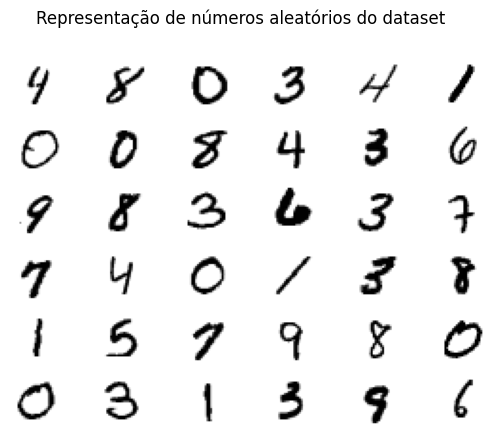

In [8]:
# Visualizando algumas instância do dataset
nums = df['class'].unique()

imgs = list()
for i in np.random.randint(100, size=36):
    rnd_choice = np.random.choice(nums)
    img = pd.array(df[df['class'] == rnd_choice].iloc[i][:-1],
                 dtype=int).reshape((28,28))
    imgs.append(img)

plot_images(imgs)


#### Separando os dados de treino e teste

In [9]:
# treino e teste
X = df.iloc[:, 0:-1].values
y = df.iloc[:, [-1]].astype('int') # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

kf = KFold(n_splits=10, shuffle=True)

### PCA test


In [63]:
pca, x_pca = do_pca(0.5, X)
approximation = pca.inverse_transform(x_pca)

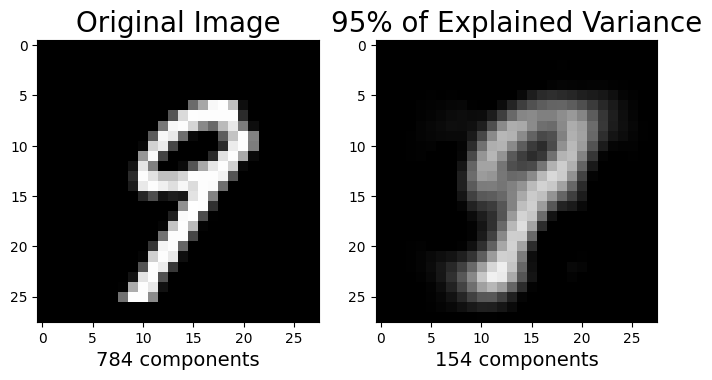

In [64]:
plt.figure(figsize=(8,4));

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(X[1].reshape(28,28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('784 components', fontsize = 14)
plt.title('Original Image', fontsize = 20);

# 154 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[1].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('154 components', fontsize = 14)
plt.title('95% of Explained Variance', fontsize = 20);

# Experimentos

### Decision Tree

In [ ]:
dt_pipeline = Pipeline([
    ('selector', VarianceThreshold()),
    ('classifier', DecisionTreeClassifier())
])
dt_params = {
    'selector__threshold': [0.5, 0, 0.1],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth':[5, 50, 100],
    'classifier__min_samples_split': [5, 10, 30],
    'classifier__max_features':[10, 30, 100, 'sqrt'],
}
dt_acc, dt_f1, dt_cm, dt_roc, dt_grid_results = grid_Search(kf, dt_pipeline, dt_params, X_train, y_train, n_jobs=-1)

print("\n-----------------------------------------------------\n")
dt_results = Results('Decision Tree', dt_acc, dt_f1,
                           dt_cm, dt_roc, dt_grid_results)
dt_results.plot()


### Naive Bayes

#### Gaussian NB

Fold 0	 Accuracy: 0.889
Model best params: {'classifier__var_smoothing': 0.01}
Fold 1	 Accuracy: 0.889
Model best params: {'classifier__var_smoothing': 0.01}
Fold 2	 Accuracy: 0.871
Model best params: {'classifier__var_smoothing': 0.01}
Fold 3	 Accuracy: 0.858
Model best params: {'classifier__var_smoothing': 0.01}
Fold 4	 Accuracy: 0.878
Model best params: {'classifier__var_smoothing': 0.01}
Fold 5	 Accuracy: 0.860
Model best params: {'classifier__var_smoothing': 0.01}
Fold 6	 Accuracy: 0.880
Model best params: {'classifier__var_smoothing': 0.01}
Fold 7	 Accuracy: 0.889
Model best params: {'classifier__var_smoothing': 0.01}
Fold 8	 Accuracy: 0.884
Model best params: {'classifier__var_smoothing': 0.001}
Fold 9	 Accuracy: 0.867
Model best params: {'classifier__var_smoothing': 0.01}

-----------------------------------------------------

Resumo das métricas do modelo GaussianNB

Accurácia média (desvio): 0.876 (0.011)
F1-Score média (desvio): 0.876 (0.012)


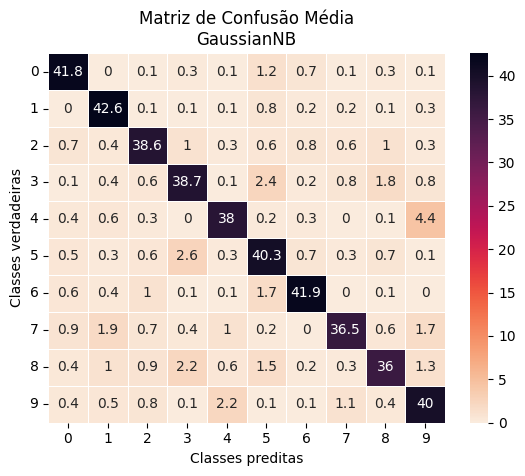

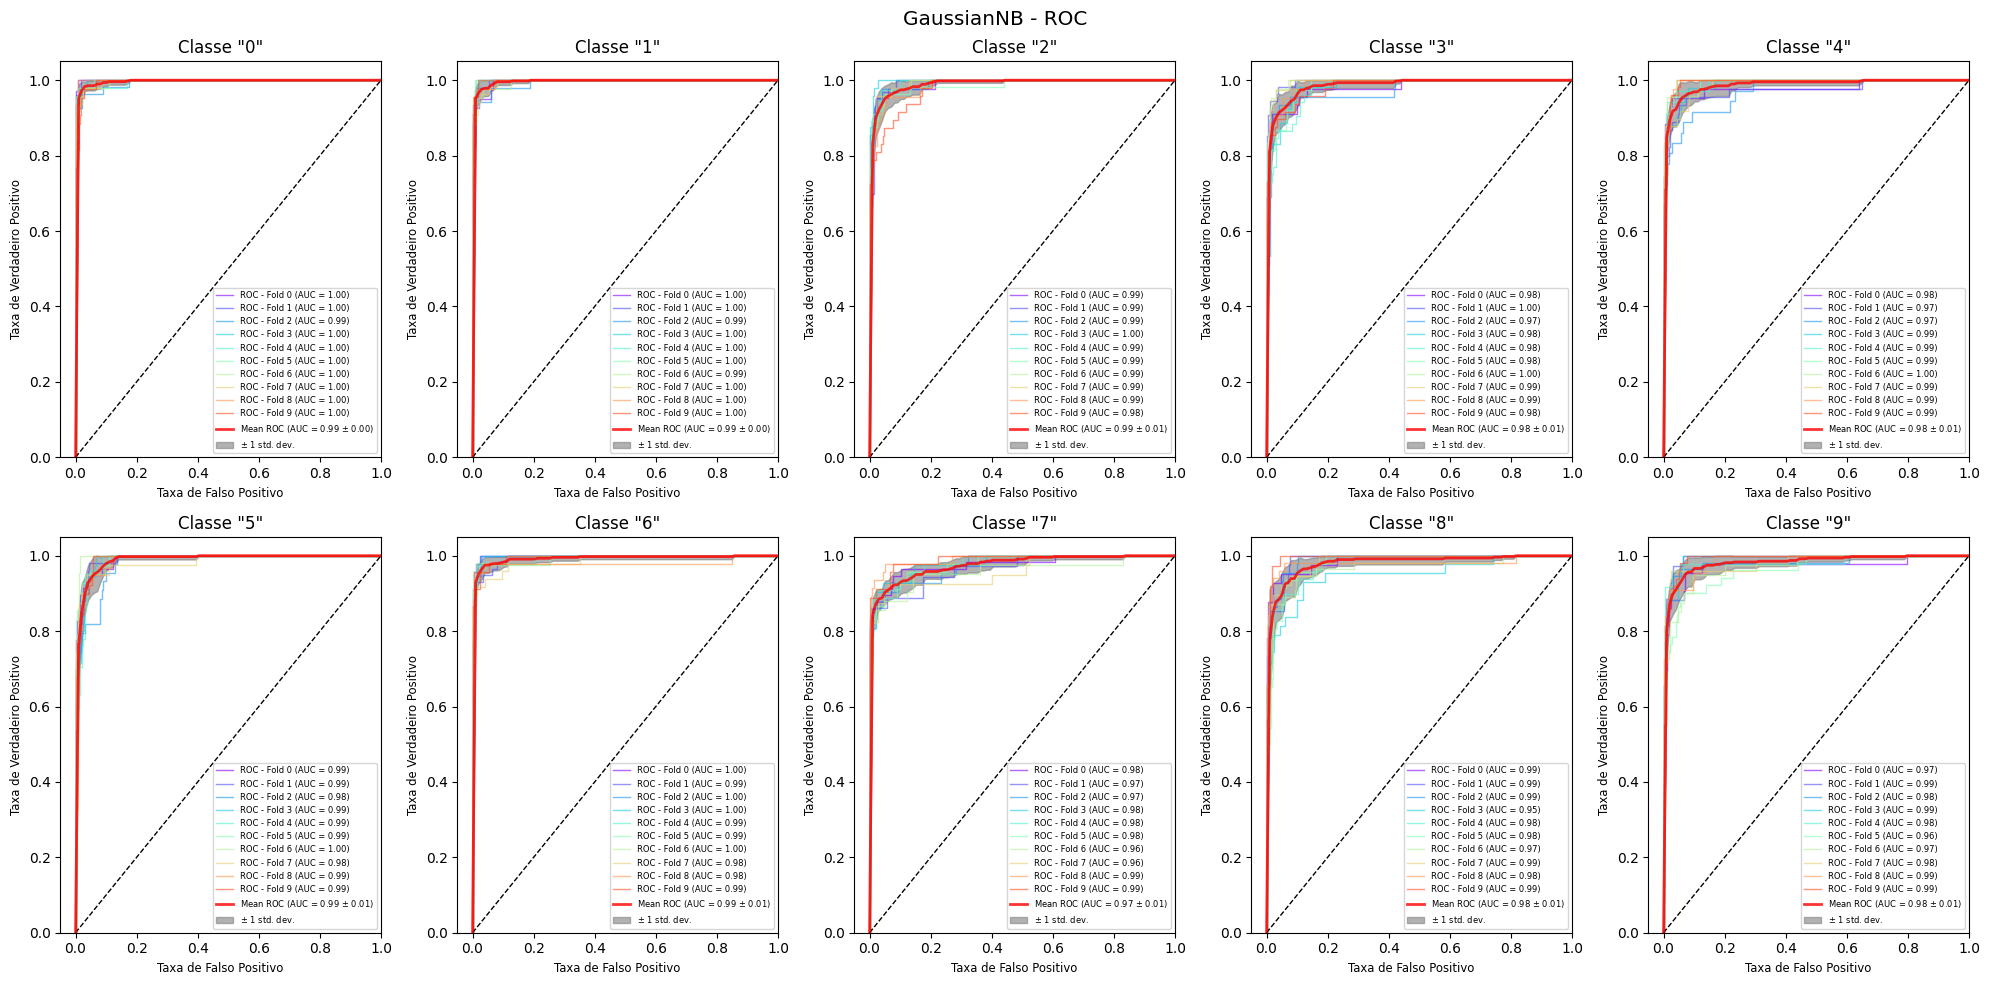

In [30]:
gnb_pipeline = Pipeline([
    # ('selector', VarianceThreshold()),
    ('classifier', GaussianNB())
])
gnb_params = {
    # 'selector__threshold': [0.5, 0, 0.1],
    'classifier__var_smoothing': np.logspace(0,-9, num=10)
}

gnb_acc, gnb_f1, gnb_cm, gnb_roc, gnb_grid_results = grid_Search(kf, gnb_pipeline, gnb_params,
                                               X_train, y_train, n_jobs=-1)

print("\n-----------------------------------------------------\n")
gnb_results = Results('GaussianNB', gnb_acc, gnb_f1,
                           gnb_cm, gnb_roc, gnb_grid_results)
gnb_results.save()
gnb_results.plot()


#### Multinomial NB

In [ ]:
mnb_pipeline = Pipeline([
    # ('selector', VarianceThreshold()),
    ('classifier', MultinomialNB())
])

mnb_params = {
    # 'selector__threshold': [0.5, 0, 0.1],
    'classifier__alpha': np.logspace(0,-9, num=10)
}

mnb_acc, mnb_f1, mnb_cm, mnb_roc, mnb_grid_results = grid_Search(kf, mnb_pipeline, mnb_params,
                                                   X_train, y_train, n_jobs=-1)


print("\n-----------------------------------------------------\n")
mnnb_results = Results('MultinomialNB', mnb_acc, mnb_f1, 
                           mnb_cm, mnb_roc, mnb_grid_results)
mnnb_results.save()
mnnb_results.plot()

### KNN

Fold 0	 Accuracy: 0.916
Model best params: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 5, 'selector__n_components': 20}
Fold 1	 Accuracy: 0.944
Model best params: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 3, 'selector__n_components': 50}
Fold 2	 Accuracy: 0.933
Model best params: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 5, 'selector__n_components': 20}
Fold 3	 Accuracy: 0.907
Model best params: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 5, 'selector__n_components': 20}
Fold 4	 Accuracy: 0.940
Model best params: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 7, 'selector__n_components': 20}
Fold 5	 Accuracy: 0.949
Model best params: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 7, 'selector__n_components': 20}
Fold 6	 Accuracy: 0.947
Model best params: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 3, 'selector__n_components': 50}
Fold 7	 Accuracy: 0.929
Mod

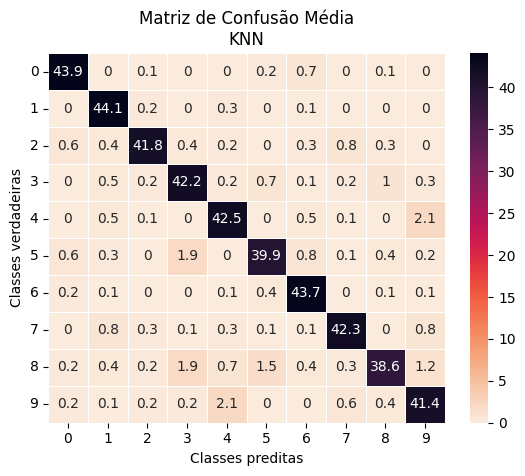

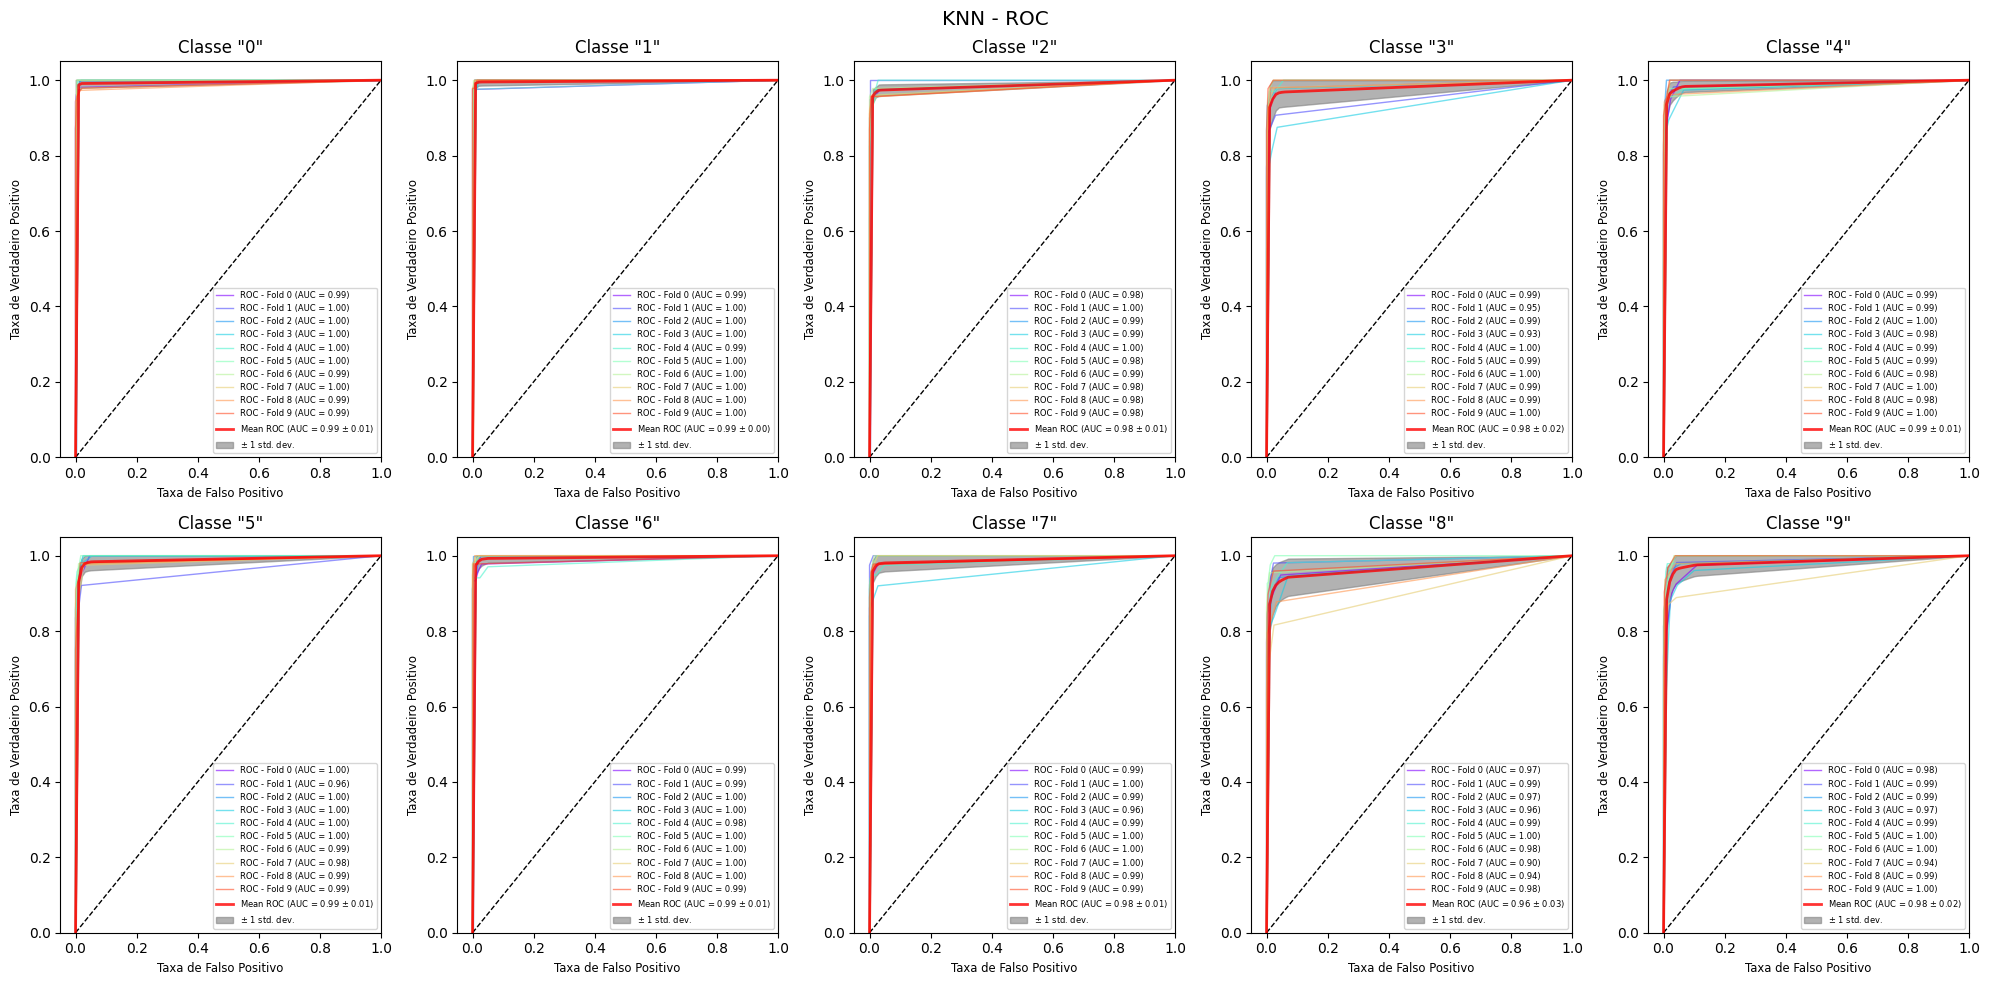

In [19]:
knn_pipeline = Pipeline([
    ('selector', PCA()),
    ('classifier', KNeighborsClassifier(n_jobs=-1))
])

knn_params = {
    'selector__n_components': [20, 50, 100, 200],
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__metric': ['euclidean', 'manhattan']
}

knn_acc, knn_f1, knn_cm, knn_roc, knn_grid_results = grid_Search(kf, knn_pipeline, knn_params, X_train, y_train, n_jobs=-1)

print("\n-----------------------------------------------------\n")
knn_results = Results('KNN', knn_acc, knn_f1, 
                           knn_cm, knn_roc, knn_grid_results)
knn_results.save()
knn_results.plot()

### SVC

In [ ]:
svc_pipeline = Pipeline([
    ('selector', VarianceThreshold()),
    ('classifier', SVC(probability=True))
])

svc_params = [
    {'selector__threshold': [0.5, 0, 0.1],
    'classifier__C': np.logspace(4,-1, num=6),
    'classifier__kernel':['linear']},
    
    {'selector__threshold': [0.5, 0, 0.1],
    'classifier__C': np.logspace(4,-1, num=6),
    'classifier__kernel': ['poly'],
    'classifier__degree': [2, 3]},
]

svc_acc, svc_f1, svc_cm, svc_roc, svc_grid_results = grid_Search(kf, svc_pipeline, svc_params,
                                               X_train, y_train, n_jobs=-1)

print("\n-----------------------------------------------------\n")
svc_results = Results('SVC', svc_acc, svc_f1, 
                           svc_cm, svc_roc, svc_grid_results)
svc_results.save()
svc_results.plot()


### MLP

In [ ]:
mlp_pipeline = Pipeline([
    ('selector', VarianceThreshold()),
    ('classifier', KerasClassifier(build_fn=MLP, n_classes=10, input_shape=(100,), verbose=0))
])

mlp_params = {
    'selector__threshold': [0.5, 0, 0.1],
    'classifier__epochs': [20, 30, 50],
    'classifier__batch_size':[128, 256],
    'classifier__n_neurons':[[500]*2, [1000]*2, [500]*3, [1000]*3],
    'classifier__optimizer': [Adam, Adamax, SGD],
    'classifier__lr': [0.001, 0.002, 0.003]
}


mlp_acc, mlp_f1, mlp_cm, mlp_roc, mlp_grid_results = grid_Search(kf, mlp_pipeline, mlp_params, X_train, y_train)

print("\n-----------------------------------------------------\n")
mlp_results = Results('MLP', mlp_acc, mlp_f1, 
                           mlp_cm, mlp_roc, mlp_grid_results)
mlp_results.save()
mlp_results.plot()


### Treinando o SVC como modelo final

In [ ]:
svc = SVC(probability=True)

svc_params = [
    {'C': np.logspace(4,-1, num=6),
     'kernel':['linear']},
    
    {'C': np.logspace(4,-1, num=6),
     'kernel': ['poly'],
     'degree': [2, 3]},
]
grid = GridSearchCV(estimator=svc, param_grid=svc_params,
                          scoring='accuracy', n_jobs=-1, 
                          cv=5, refit=True)

grid.fit(X_train ,y_train.values.ravel())

GridSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=-1,
             param_grid=[{'C': array([1.e+04, 1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01]),
                          'kernel': ['linear']},
                         {'C': array([1.e+04, 1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01]),
                          'degree': [2, 3], 'kernel': ['poly']}],
             scoring='accuracy')

In [ ]:
best_model = SVC(**grid.best_params_, probability=True)

best_model.fit(X_train, y_train.values.ravel())

SVC(C=10000.0, degree=2, kernel='poly', probability=True)

In [ ]:
from sklearn.metrics import classification_report
y_pred = best_model.predict(X_test)
y_score = best_model.predict_proba(X_test)

print(classification_report(y_test, y_pred, digits=3))


              precision    recall  f1-score   support

           0      0.931     0.964     0.947        56
           1      0.909     1.000     0.952        40
           2      0.964     0.931     0.947        58
           3      0.945     0.912     0.929        57
           4      0.941     1.000     0.970        48
           5      0.935     0.935     0.935        46
           6      0.978     0.978     0.978        46
           7      0.947     0.964     0.956        56
           8      0.947     0.900     0.923        40
           9      0.980     0.906     0.941        53

    accuracy                          0.948       500
   macro avg      0.948     0.949     0.948       500
weighted avg      0.949     0.948     0.948       500

